# Pneumococcal Data Analysis

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [82]:
HOME_DIR = "/Users/martinemons/polybox/Universitaet/MSc_CBB/FS2021/IDD-rotation/IDD_TB"

In [83]:
df = pd.read_csv(HOME_DIR + "/data/PneumoData.csv")

### Data Handling

In [84]:
df

,Accession,Strain Name,Taxon ID,Strain Cluster (SC),Year of Isolation,Community of Isolation,Host Age (months),Serotype,Capsule locus,Consensus serotype,Sequence type,Inferred sequence type,Benzylpenicillin MIC (_g/mL),Ceftriaxone MIC (_g/mL),Trimethoprim MIC (_g/mL),Erythromycin MIC (_g/mL),Tetracycline MIC (_g/mL),Chloramphenicol MIC (_g/mL)
0,ERR129088,CH2079,5Z52R,1,2007,C,Jun-24,10A,10A,10A,816.0,816,0.023,0.023,0.125,0.064,NaN,NaN
1,ERR129126,LE4000,N5O68,1,2007,D,24-36,10A,10A,10A,3290.0,3290,0.023,0.023,0.094,0.094,NaN,NaN
2,ERR129158,LE4124,RUJ90,1,2007,D,24-36,10A,10A,10A,816.0,816,0.023,0.023,0.19,0.047,NaN,NaN
3,ERR129164,MD5021,29ORI,1,2007,E,Jun-24,10A,10A,10A,816.0,816,0.032,0.032,0.125,0.064,NaN,NaN
4,ERR129199,ND6034,RN3X8,1,2007,F,36-84,10A,10A,10A,816.0,816,0.023,0.032,0.25,0.094,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,ERR069838,388483,388483,16,2001,H,36-84,6B,NT,6B,146.0,146,0.25,0.5,>4/76,>1,0.25,NaN
612,ERR069840,397079,397079,16,2001,J,36-84,6B,6A,6B,315.0,315,0.25,0.06,0.5/9.,>1,>8,NaN
613,ERR065957,436154,436154,16,2001,P,Jun-24,6B,6A,6B,1954.0,1954,1,0.5,0.25/4,<0.03,0.12,NaN
614,ERR069769,132571,132571,16,2001,N,Jun-24,9N,9N,9N,405.0,405,<0.03,<0.03,0.25/4,<0.03,0.25,NaN


In the early 2000's the Prevnar vaccine was approved by the FDA for usage in children. It is a vaccine agains *Streptococcus pneumoniae*. It targets the serotypes 4, 6B, 9V, 14, 18C, 19F, and 23F according to the FDA. This means we can classify the vaccine type as being all but those infected with the strains that were in the Prevnar vaccine and the rest as being non-vaccine type

In [85]:
#df['Price'] = [1500 if x =='Music' else 800 for x in df['Event']] 
  
# Print the DataFrame 
#print(df)

#set all the types included in the Prevnar Vaccine to be non-vaccinated
dic = {'4': 'non-vaccinated', '6B': 'non-vaccinated', '9V': 'non-vaccinated', '14': 'non-vaccinated', '18C': 'non-vaccinated', '19F': 'non-vaccinated', '23F': 'non-vaccinated'}

#then set all to be non-vaccine that are infected with the strains included in the Prevnar vaccine
df['Vaccine-type'] = df['Serotype'].map(dic) 

#set the rest (denoted as NaN) to be vaccinated
df['Vaccine-type'] = df['Vaccine-type'].fillna('vaccinated')

one can define whether the pneumococcal isolate is resistant or sensitive whether the minimum inhibitory concentration (MIC) is above or below a certain threshold. We will perform this analysis first for a single antibiotic, namely benzylpenicillin. An MIC for benzylpenicillin above 0.06 is considered as being resistant

In [86]:
#converting first every entry into a string
df['Benzylpenicillin MIC (_g/mL)'] = df['Benzylpenicillin MIC (_g/mL)'].astype(str)

#cutting away the '<' and '<=' etc.
df['Benzylpenicillin MIC (_g/mL)'] = df['Benzylpenicillin MIC (_g/mL)'].map(lambda x: x.lstrip('<>='))

#mapping every entry back to a float
df['Benzylpenicillin MIC (_g/mL)'] = df['Benzylpenicillin MIC (_g/mL)'].astype(float)

#setting every value above 0.06 to be resistant and sensitive otherwise
df['Resistance-type'] = ['resistant' if x > 0.06 else 'sensitive' for x in df['Benzylpenicillin MIC (_g/mL)']]

In [87]:
df

,Accession,Strain Name,Taxon ID,Strain Cluster (SC),Year of Isolation,Community of Isolation,Host Age (months),Serotype,Capsule locus,Consensus serotype,Sequence type,Inferred sequence type,Benzylpenicillin MIC (_g/mL),Ceftriaxone MIC (_g/mL),Trimethoprim MIC (_g/mL),Erythromycin MIC (_g/mL),Tetracycline MIC (_g/mL),Chloramphenicol MIC (_g/mL),Vaccine-type,Resistance-type
0,ERR129088,CH2079,5Z52R,1,2007,C,Jun-24,10A,10A,10A,816.0,816,0.023,0.023,0.125,0.064,NaN,NaN,vaccinated,sensitive
1,ERR129126,LE4000,N5O68,1,2007,D,24-36,10A,10A,10A,3290.0,3290,0.023,0.023,0.094,0.094,NaN,NaN,vaccinated,sensitive
2,ERR129158,LE4124,RUJ90,1,2007,D,24-36,10A,10A,10A,816.0,816,0.023,0.023,0.19,0.047,NaN,NaN,vaccinated,sensitive
3,ERR129164,MD5021,29ORI,1,2007,E,Jun-24,10A,10A,10A,816.0,816,0.032,0.032,0.125,0.064,NaN,NaN,vaccinated,sensitive
4,ERR129199,ND6034,RN3X8,1,2007,F,36-84,10A,10A,10A,816.0,816,0.023,0.032,0.25,0.094,NaN,NaN,vaccinated,sensitive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,ERR069838,388483,388483,16,2001,H,36-84,6B,NT,6B,146.0,146,0.250,0.5,>4/76,>1,0.25,NaN,non-vaccinated,resistant
612,ERR069840,397079,397079,16,2001,J,36-84,6B,6A,6B,315.0,315,0.250,0.06,0.5/9.,>1,>8,NaN,non-vaccinated,resistant
613,ERR065957,436154,436154,16,2001,P,Jun-24,6B,6A,6B,1954.0,1954,1.000,0.5,0.25/4,<0.03,0.12,NaN,non-vaccinated,resistant
614,ERR069769,132571,132571,16,2001,N,Jun-24,9N,9N,9N,405.0,405,0.030,<0.03,0.25/4,<0.03,0.25,NaN,vaccinated,sensitive


now the idea is to take a subset of the data, the non-vaccinated individuals, and make the rest of the inference based on these. The question we are asking how does antibiotic resistance behave in the non-vaccinated group after we reduced the amount of available host via vaccination.

In [183]:
#select those individuals where the vaccine-type is non-vaccinated
df_nonvacc = df[df['Vaccine-type']=='non-vaccinated']

In [184]:
df_nonvacc

,Accession,Strain Name,Taxon ID,Strain Cluster (SC),Year of Isolation,Community of Isolation,Host Age (months),Serotype,Capsule locus,Consensus serotype,Sequence type,Inferred sequence type,Benzylpenicillin MIC (_g/mL),Ceftriaxone MIC (_g/mL),Trimethoprim MIC (_g/mL),Erythromycin MIC (_g/mL),Tetracycline MIC (_g/mL),Chloramphenicol MIC (_g/mL),Vaccine-type,Resistance-type
68,ERR129077,CH2029,STPDE,5,2007,C,<6,9V,9V,9V,162.0,162,0.023,0.023,0.25,0.094,NaN,NaN,non-vaccinated,sensitive
84,ERR129172,MD5037,UB6XH,6,2007,E,Jun-24,6B,6A,6B,138.0,138,0.023,0.016,0.25,0.047,NaN,NaN,non-vaccinated,sensitive
150,ERR129146,LE4081,ZXPKH,9,2007,D,Jun-24,23F,23A,23A,42.0,42,0.023,0.023,0.125,0.064,NaN,NaN,non-vaccinated,sensitive
227,ERR129062,BR1111,6GU7V,15,2007,J,<6,19F,19F,19F,3292.0,3292,1.000,0.5,>32,>256,NaN,NaN,non-vaccinated,resistant
228,ERR129078,CH2033,WMK3T,15,2007,C,36-84,19F,19F,19F,236.0,236,3.000,1.5,6,4,NaN,NaN,non-vaccinated,resistant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,ERR069813,302649,302649,16,2001,J,36-84,6B,6A,6B,146.0,146,0.030,<0.03,Feb-38,>1,0.5,NaN,non-vaccinated,sensitive
610,ERR069819,323485,323485,16,2001,P,36-84,6B,NT,6B,146.0,146,0.030,<0.03,0.25/4,<0.03,0.5,NaN,non-vaccinated,sensitive
611,ERR069838,388483,388483,16,2001,H,36-84,6B,NT,6B,146.0,146,0.250,0.5,>4/76,>1,0.25,NaN,non-vaccinated,resistant
612,ERR069840,397079,397079,16,2001,J,36-84,6B,6A,6B,315.0,315,0.250,0.06,0.5/9.,>1,>8,NaN,non-vaccinated,resistant


In [185]:
df_nonvacc['Resistance-type'].value_counts()

sensitive    45
resistant    34
Name: Resistance-type, dtype: int64

In [187]:
#group by year of isolation and resistance type then count the occurences
df_nonvacc_freq = df_nonvacc.groupby(['Year of Isolation', 'Resistance-type']).size().reset_index()

#rename the columns
df_nonvacc_freq.columns = ['Year of Isolation', 'Resistance-type', 'Counts']

In [228]:
#in order to normalise
norm = df_nonvacc['Year of Isolation'].value_counts()
norm.to_frame()

newdf = pd.DataFrame(np.repeat(norm.values,2,axis=0))
newdf.columns = ['norm']
print(newdf)

   norm
0    40
1    40
2    29
3    29
4    10
5    10


In [229]:
df_nonvacc_freq['Relative Frequencies'] = df_nonvacc_freq['Counts']/newdf['norm']

In [230]:
df_nonvacc_freq

,Year of Isolation,Resistance-type,Counts,Relative Frequencies
0,2001,resistant,17,0.425000
1,2001,sensitive,23,0.575000
2,2004,resistant,14,0.482759
3,2004,sensitive,15,0.517241
4,2007,resistant,3,0.300000
5,2007,sensitive,7,0.700000


<AxesSubplot:xlabel='Year of Isolation'>

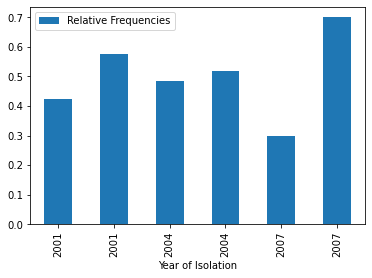

In [231]:
#plot the histogram
#fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
# pd.bar(df_nonvacc_freq['Resistance-type'], height = df_nonvacc_freq['Relative Frequencies'])
#axs[1].bar(df_nonvacc_freq['Relative Frequencies'])

df_nonvacc_freq.plot.bar(x='Year of Isolation', y = 'Relative Frequencies')